In [134]:
%matplotlib inline  
from IPython.display import clear_output
from math import isnan
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
from ipywidgets import FloatSlider, BoundedFloatText, Dropdown, Button, BoundedIntText, IntSlider, Button, jslink
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

TYPE_WALL = 'стена'
TYPE_PIPE = 'труба'
TYPE_WINDOW = 'окно'


surface_type_input = Dropdown(
    options=[TYPE_WALL, TYPE_PIPE, TYPE_WINDOW],
    value=TYPE_WALL,
    description='Тип поверхности'
)

TYPE_SONATA = 'Соната-АВ'
TYPE_VNG = 'VNG-012GL'

defence_type_input = Dropdown(
    options=[TYPE_SONATA, TYPE_VNG],
    value=TYPE_SONATA,
    description='Виброакустич. защита'
)

LEVEL_MEDIUM = 'средний'
LEVEL_LOUD = 'громкий'
LEVEL_VERY_LOUD = 'очень громкий'

signal_level_input = Dropdown(
    options=[LEVEL_MEDIUM, LEVEL_LOUD, LEVEL_VERY_LOUD],
    value=LEVEL_MEDIUM,
    description='Уровень скрываемого сигнала'
)


PROFILE_MIN = 'минимальный'
PROFILE_MED = 'средний'
PROFILE_MAX = 'максимальный'

profile_input = Dropdown(
    options=[PROFILE_MIN, PROFILE_MED, PROFILE_MAX],
    value=PROFILE_MED,
    description='Профиль защиты'
)


clarity_input_text = BoundedFloatText(
    description='Слов. разб. речи',
    value=0.25,
    min=0.0,
    max=1.0,
)
clarity_input = FloatSlider(
    min=0.0,
    max=1.0,
    step=0.001,
    value=0.25
)

link = jslink((clarity_input_text, 'value'), (clarity_input, 'value'))


width_input_text = BoundedIntText(
    description='Ширина (в клетках)',
    min=1,
    max=100,
    value=15
)
width_input = IntSlider(
    min=1,
    max=100,
    value=15
)
link = jslink((width_input_text, 'value'), (width_input, 'value'))



height_input_text = BoundedIntText(
    description='Высота (в клетках)',
    min=1,
    max=100,
    value=15
)
height_input = IntSlider(
    min=1,
    max=100,
    value=15
)
link = jslink((height_input_text, 'value'), (height_input, 'value'))


run_btn = Button(description='Запуск')

        

# Добавление виброизлучателей:

Добавить в следующую ячейку значение в виде
(ширина, высота)

Ширина - квадрат, в котором установить виброизлучатель (1...max_ширина)
Высота - -//-

In [135]:
def color(value, clarity):
    if value <= clarity:
        return 'green'
    elif value <= clarity + 0.1:
        return 'yellow'
    else:
        return 'red'



def render(width, height, vibes, tiles, tile_size=0.1, clarity=0.4): 
    fig1 = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    ax1 = fig1.add_subplot(111, aspect='equal')
    for p in [

                
            patches.Rectangle(
                    np.multiply(tiles[i]["position"], tile_size) - tile_size,
                    tile_size,
                    tile_size,
                    facecolor=color(tiles[i]['value'], clarity)
                    ) for i in range(len(tiles))
    ]:
        ax1.add_patch(p)
        for vibe in vibes:
            circle = plt.Circle(
                (vibe[0] * tile_size - tile_size / 2, vibe[1] * tile_size - tile_size / 2), 
                tile_size / 3, 
                color='Blue'
            )
            ax1.add_artist(circle)
    plt.axis([0, np.ceil(tile_size * width), 0, np.ceil(tile_size * height)])
            


In [136]:
# Переводим все значения из таблиц А.1-А.8
# исх. данные
# уровень тест сигнала средний
# уровень излучения виброизлучателя максимальный
#датчик-соната АВ тяжелый
# ограждающая конструкция стена



#Значение  формантного параметра речи в полосе DAi, дБ
def DA(i):
    return [25, 18, 14, 9, 6, 5, 4][i - 1]

def k(i):
    return [0.01, 0.03, 0.12, 0.2, 0.3, 0.26, 0.07][i - 1]

#Уровень виброускорения от тестового речевого сигнала (Средняя речь) Vсi, дБ
def Vc(i, surface_type, signal_level):
    if surface_type == TYPE_PIPE: # труба
        if signal_level == LEVEL_MEDIUM:
            return [36, 39.7, 38.7, 42, 33.6, 31.2, 27.6][i - 1]
        elif signal_level == LEVEL_LOUD:
            return [37, 48.3, 50, 50.7, 38.2, 54.4, 37.2][i - 1]
        elif signal_level == LEVEL_VERY_LOUD:
            return [43.6, 55.9, 54.2, 60.5, 44.3, 62.4, 42.7][i - 1]
    elif surface_type == TYPE_WALL: # стена
        if signal_level == LEVEL_MEDIUM:
            return [37, 42.5, 48.8, 53.1, 47.9, 31.6, 29.3][i - 1]
        elif signal_level == LEVEL_LOUD:
            return [42.3, 51.6, 60.5, 57.4, 52.8, 55.8, 43.9][i - 1]
        elif signal_level == LEVEL_VERY_LOUD:
            return [48.4, 58, 68.9, 68.5, 59, 63.8, 49.3][i - 1]
    elif surface_type == TYPE_GLASS: # окно
        if signal_level == LEVEL_MEDIUM:
            return [53.6, 49,6, 46.2, 48.6, 39.4, 29.8, 29.5][i - 1]
        elif signal_level == LEVEL_LOUD:
            return [57.5, 58, 58, 53, 43.5, 52.5, 42][i - 1]
        elif signal_level == LEVEL_VERY_LOUD:
            return [64, 65.5,65.6, 64.3, 49.7, 60.5, 47.6][i - 1]
 

# Уровень шума от системы защиты V*, дБ
#(уровень максимальный)
def Vstar(i, surface_type, profile, defence_type):
    if surface_type == TYPE_WALL:
        if defence_type == TYPE_SONATA:
            if profile == PROFILE_MIN:
                return [60.4, 81.8, 83.2, 87.4, 75, 70.2, 57.6][i - 1]
            elif profile == PROFILE_MED:
                return [60.4, 81.8, 83.2, 87.4, 75, 70.2, 57.6][i - 1]
            elif profile == PROFILE_MAX:
                return [60.4, 81.8, 83.2, 87.4, 75, 70.2, 57.6][i - 1]
        elif defence_type == TYPE_VNG:
            if profile == PROFILE_MIN:
                return [60.4, 81.8, 83.2, 87.4, 75, 70.2, 57.6][i - 1]
            elif profile == PROFILE_MED:
                return [60.4, 81.8, 83.2, 87.4, 75, 70.2, 57.6][i - 1]
            elif profile == PROFILE_MAX:
                return [60.4, 81.8, 83.2, 87.4, 75, 70.2, 57.6][i - 1]
    elif surface_type == TYPE_PIPE:
        if defence_type == TYPE_SONATA:
            if profile == PROFILE_MIN:
                return [60.4, 81.8, 83.2, 87.4, 75, 70.2, 57.6][i - 1]
            elif profile == PROFILE_MED:
                return [60.4, 81.8, 83.2, 87.4, 75, 70.2, 57.6][i - 1]
            elif profile == PROFILE_MAX:
                return [60.4, 81.8, 83.2, 87.4, 75, 70.2, 57.6][i - 1]
        elif defence_type == TYPE_VNG:
            if profile == PROFILE_MIN:
                return [60.4, 81.8, 83.2, 87.4, 75, 70.2, 57.6][i - 1]
            elif profile == PROFILE_MED:
                return [60.4, 81.8, 83.2, 87.4, 75, 70.2, 57.6][i - 1]
            elif profile == PROFILE_MAX:
                return [60.4, 81.8, 83.2, 87.4, 75, 70.2, 57.6][i - 1]
    elif surface_type == TYPE_GLASS:
        if defence_type == TYPE_SONATA:
            if profile == PROFILE_MIN:
                return [60.4, 81.8, 83.2, 87.4, 75, 70.2, 57.6][i - 1]
            elif profile == PROFILE_MED:
                return [60.4, 81.8, 83.2, 87.4, 75, 70.2, 57.6][i - 1]
            elif profile == PROFILE_MAX:
                return [60.4, 81.8, 83.2, 87.4, 75, 70.2, 57.6][i - 1]
        elif defence_type == TYPE_VNG:
            if profile == PROFILE_MIN:
                return [60.4, 81.8, 83.2, 87.4, 75, 70.2, 57.6][i - 1]
            elif profile == PROFILE_MED:
                return [60.4, 81.8, 83.2, 87.4, 75, 70.2, 57.6][i - 1]
            elif profile == PROFILE_MAX:
                return [60.4, 81.8, 83.2, 87.4, 75, 70.2, 57.6][i - 1]

def Ln(i, surface_type, profile, defence_type):
    return 10 ** (Vstar(i, surface_type, profile, defence_type) / 20) * (10 ** (-6))


def Lsh_coefficients(i, surface_type):
    if surface_type == TYPE_WALL:
        return [1659.587, 275.4229, 120.2264, 98.8553, 113.5011, 74.1310, 285.1018][i - 1]
    elif surface_type == TYPE_PIPE:
        return [822.2426, 660.6963, 167.8804, 105.9254, 38.01894, 88.10489, 1640.59][i - 1]
    elif surface_type == TYPE_GLASS:
        return [31260.8, 6095.37, 785.236, 118.85, 38.9045, 68.3912, 250.07][i - 1]
 
def Lsh_val_coefficients_right(i, surface_type):
    if surface_type == TYPE_WALL:
        return [0.00006, 0.0003, 0.001, 0.001, 0.001, 0.002, 0.0006][i - 1]
    elif surface_type == TYPE_PIPE:
        return [0.0001, 0.0001, 0.0005, 0.0007, 0.003, 0.001, 0.00005][i - 1]
    elif surface_type == TYPE_GLASS:
        return [0.000002, 0.000009, 0.00007, 0.001, 0.004, 0.001, 0.0004][i - 1]
 
 
def Lsh_val_coefficients_left(i, surface_type):
    if surface_type == TYPE_WALL:
        return [0.0004, 0.0027, 0.0054, 0.0074, 0.0057, 0.0082, 0.0019][i - 1]
    elif surface_type == TYPE_PIPE:
        return [0.0008, 0.0011, 0.0046, 0.0075, 0.0184, 0.0081, 0.0005][i - 1]
    elif surface_type == TYPE_GLASS:
        return [0.00003, 0.0001, 0.0011, 0.0051, 0.015, 0.0114, 0.015][i - 1]
    
    
def Lsh(i, x, surface_type, defence_type, profile):
    #5, 17.69
    return (
        Lsh_coefficients(i, surface_type) * 
        Ln(i, surface_type, profile, defence_type) * 
        (
            Lsh_val_coefficients_left(i, surface_type) - (
                Lsh_val_coefficients_right(i, surface_type) *
                np.log(x)
            )
        )
    )
    #return [Lsh1, Lsh2, Lsh3, Lsh4, Lsh5, Lsh6, Lsh7][i - 1](x, surface_type, defence_type, profile)

def Vsh(i, x, surface_type, defence_type, profile): # CORRECT
    #print("Vsh={}, i={}, x={}".format(20 * np.log10(Lsh(i, x)) + 120, i, x))
    for y in x:
        if Lsh(i, y, surface_type, defence_type, profile) < 0.0:
            print(i, y) 

    return np.sqrt(
        np.sum(
            np.power(
                [20 * np.log10(Lsh(i, y, surface_type, defence_type, profile)) + 120 for y in x], 
                2.0
            )
        )
    )
    #return 20 * np.log10(Lsh(i, x)) + 120, 2.0

def q(i, x, surface_type, defence_type, signal_level, profile):
    #print('VSh value={}'.format(Vsh(i, x)))
    return Vc(i, surface_type, signal_level) - Vsh(i, x, surface_type, defence_type, profile)

def Qi(i, x, surface_type, defence_type, signal_level, profile):
    #print("Qi, i={}, x={}, Qi={}".format(i, x, q(i,x) - DA(i)))
    return q(i, x, surface_type, defence_type, signal_level, profile) - DA(i)

def p(i, x, surface_type, defence_type, signal_level, profile):
    Q = Qi(i, x, surface_type, defence_type, signal_level, profile)
    
    val = (
        0.78 + 
        5.46 * 
        np.exp(-4.3 * (10 ** -3) * ((27.3 - np.abs(Q)) ** 2))
    ) / (
        1 + (10 ** (0.1 * np.abs(Q)))
    )
    
    
    if Q <= 0:
        #print("p: i={}, x={}, val={}, Q={}".format(i, x, val, Q))
        return val
    else:
        #print("p: i={}, x={}, val={}, Q={}".format(i, x, 1 - val, Q))
        return 1 - val
    
def Ri(i, x, surface_type, defence_type, signal_level, profile):
    return p(i, x, surface_type, defence_type, signal_level, profile) * k(i)

def W(x, surface_type, defence_type, signal_level, profile):
    R = np.sum(Ri(i + 1, x, surface_type, defence_type, signal_level, profile) for i in range(7))
    if isnan(R):
        print('NAN: {}'.format(x))
    if R < 0.15: 
        return 1.54 * (R ** (0.25)) * (1 - np.exp(-11 * R))
    else: 
        return 1 - np.exp(-(11 * R) / (1 + 0.7 * R))


In [137]:
def f(x, y, vibe, tile_size):
    vx, vy = vibe
    distance = np.sqrt(np.sum(np.square([(x - vx) * tile_size, (y - vy) * tile_size])))
    if distance > 0:
        return W(distance)
    else:
        return 0.0
    
def distance(x, vx, y, vy, tile_size):
    return np.sqrt(
        np.sum(
            np.power([(x - vx) * tile_size, (y - vy) * tile_size], 2.0)))

def f2(x, y, vibes, tile_size, surface_type, defence_type, signal_level, profile):
    if any([(x - vx) < 0.01 and (y - vy) < 0.01 for (vx, vy) in vibes]):
        return 0.0
    else:
        distances = np.array([
            distance(x, vx, y, vy, tile_size) 
            for (vx, vy) in vibes
            if distance(x, vx, y, vy, tile_size) > 0.0 
        ])
        
        #print(distances)

        return W(distances, surface_type, defence_type, signal_level, profile)


def generate_tile(x, y, vibes, surface_type, defence_type, signal_level, profile, clarity, tile_size):
    value = f2(x, y, vibes, tile_size, surface_type, defence_type, signal_level, profile)
    
    return { "position": (x, y), "value": value }

In [138]:
vibe_inputs = []

def calculate_everything(b):
    clear_output()
    surface_type = surface_type_input.value
    defence_type = defence_type_input.value
    signal_level = signal_level_input.value
    profile = profile_input.value
    clarity = clarity_input.value
    width = width_input.value
    height = height_input.value
    
    vibes = [
        (v['x'].value, v['y'].value) for v in vibe_inputs
    ]
    
    if surface_type == TYPE_WALL:
        tile_size = 1.0
    else:
        tile_size = 0.1
    
    tiles = [
        generate_tile(
            x + 1, 
            y + 1, 
            vibes=vibes,
            surface_type=surface_type,
            defence_type=defence_type,
            signal_level=signal_level,
            profile=profile,
            clarity=clarity,
            tile_size=tile_size
        ) 
        for x in range(width) for y in range(height)
    ]
    
    render(width, height, vibes, tiles, tile_size=tile_size, clarity=clarity)


run_btn.on_click(calculate_everything)

[{'x': <ipywidgets.widgets.widget_int.BoundedIntText object at 0x7f0f328b6ef0>, 'y': <ipywidgets.widgets.widget_int.BoundedIntText object at 0x7f0f328b6630>}, {'x': <ipywidgets.widgets.widget_int.BoundedIntText object at 0x7f0f328b6710>, 'y': <ipywidgets.widgets.widget_int.BoundedIntText object at 0x7f0f328b6128>}]
[(1, 1), (1, 5)]


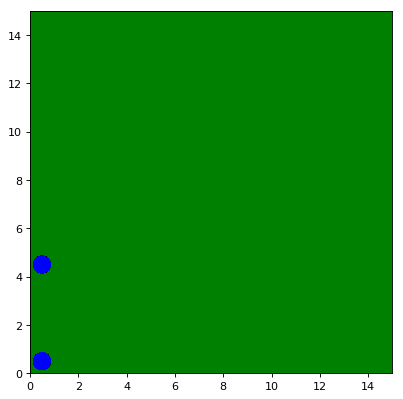

In [139]:
vibes_input_text = BoundedIntText(
    description='Число виброизлучателей',
    min=1,
    max=10,
    value=2
)
vibes_input = IntSlider(
    min=1,
    max=10,
    value=2
)
link = jslink((vibes_input_text, 'value'), (vibes_input, 'value'))

vibe_number_confirm = Button(description='Подтвердить')


def on_vibe_number_confirm_click(b):     
    vibe_count = vibes_input.value
    
    global vibe_inputs
    
    vibe_inputs = [{
        'x': BoundedIntText(
            description='Виброизл. №{}: X'.format(i + 1),
            min=1,
            value=1,
            max=100
        ),
        'y': BoundedIntText(
            description='Виброизл. №{}: Y'.format(i + 1),
            min=1,
            value=1,
            max=100
        )
        
    } for i in range(vibe_count)]
    
    vibe_inputs_to_display = [inp for inputs in vibe_inputs for (_, inp) in inputs.items()]

    display(*vibe_inputs_to_display)
    
    display(
        surface_type_input, 
        defence_type_input, 
        signal_level_input,
        profile_input,
        clarity_input_text,
        clarity_input,
        width_input_text, 
        width_input, 
        height_input_text, 
        height_input, 
        run_btn
    )

vibe_number_confirm.on_click(on_vibe_number_confirm_click)

display(
    vibes_input_text,
    vibes_input,
    vibe_number_confirm
)